In [1]:
import copy

from Utilities import *
from PuzzlePiece import *

In [2]:
# gather all the pieces
target_pieces = {}
tried_pieces = {}

for p in ['C','N','NE','E','SE','S','SW','W','NW']:
    target_pieces[p] = Piece('representations/' + p + '_border_ordered.csv')

In [3]:
# get the first piece
query = target_pieces.pop('C') # this piece will grow 
tried_pieces['C'] = copy.deepcopy(query) # keep a copy in case we need to go back 

In [4]:
# find the closest match in the other pieces
mx_score = 0
mx_piece = ''

alignments = {}
for p in target_pieces:
    # need an alignment object to store the results from these 
    target_rev = { i:target_pieces[p].sampled_pts[i]
                   for i in list(target_pieces[p].sampled_pts.keys())[::-1] }
    SuffTable, mx, mx_Q, mx_T, length = \
        AlignPieces_Euclid(query.sampled_pts, target_rev, window = 10)
    
    sims = []
    for i in range(1,len(SuffTable)):
        for j in range(1,len(SuffTable[i])):
            sims.append(SuffTable[i][j])

    sims.sort()
    cutoff = sims[int(len(sims)*.01)]
    
    # could build the dynamic programming table here
    SuffTable, mx, mx_Q, mx_T, length = \
        AlignPieces_Euclid(query.sampled_pts, target_rev,
                           mode = 'SW align', window = 10, cutoff = cutoff,
                           distr_score = False, avg = avg(sims), sd = sd(sims))
    
    print(p, mx, mx_Q, mx_T, length, mx/length)
    alignments[p] = { 'SuffTable': SuffTable,
                      'mx_score': mx,
                      'mx_Q': mx_Q,
                      'mx_T': mx_T,
                      'length': length,
                      'cutoff': cutoff}
    
    if mx > mx_score:
        mx_score = mx
        mx_piece = p
        
print('Best: ', mx_piece, mx_score, length)

N 45 181 165 44 1.0227272727272727
NE 42 124 187 41 1.024390243902439
E 44 181 189 43 1.0232558139534884
SE 12 148 155 11 1.0909090909090908
S 35 69 71 34 1.0294117647058822
SW 15 52 45 14 1.0714285714285714
W 22 22 98 20 1.1
NW 23 23 83 21 1.0952380952380953
Best:  N 45 21


In [5]:
mx_piece_rev = { i:target_pieces[mx_piece].sampled_pts[i]
                    for i in list(target_pieces[mx_piece].sampled_pts.keys())[::-1] }

mx_alignment = alignments[mx_piece]
SuffTable = mx_alignment['SuffTable']
mx = mx_alignment['mx_score']
mx_Q = mx_alignment['mx_Q']
mx_T = mx_alignment['mx_T']
length = mx_alignment['length']
cutoff = mx_alignment['cutoff']

print(mx_piece, mx, mx_Q, mx_T, length, mx/length)
target = target_pieces.pop(mx_piece)

N 45 181 165 44 1.0227272727272727


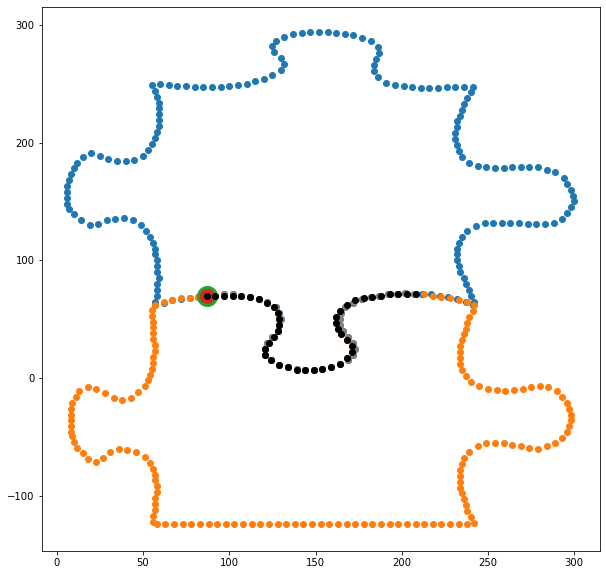

In [6]:
#find the best matched point - this is the end of the best match window
Q_pt = query.sampled_pts[list(query.sampled_pts.keys())[mx_Q-1]]
T_pt = target.sampled_pts[list(target.sampled_pts.keys())[::-1][mx_T-1]] 

# find x,y shift to align pieces
T_xshift = T_pt['x'] - Q_pt['x']
T_yshift = T_pt['y'] - Q_pt['y'] 

plt.figure(figsize = [10,10])
plt.scatter( [query.sampled_pts[k]['x'] for k,v in query.sampled_pts.items() ],
             [query.sampled_pts[k]['y'] for k,v in query.sampled_pts.items() ])
plt.scatter( [target.sampled_pts[k]['x'] - T_xshift for k,v in target.sampled_pts.items() ],
             [target.sampled_pts[k]['y'] - T_yshift for k,v in target.sampled_pts.items() ])

plt.plot( [Q_pt['x'], T_pt['x'] - T_xshift],
          [Q_pt['y'], T_pt['y'] - T_yshift],
        linewidth = 3)

# show best matched points - second will overplot first due to alignment
plt.scatter( Q_pt['x'], Q_pt['y'], s=400)
plt.scatter( T_pt['x'] - T_xshift, T_pt['y'] - T_yshift, s=196 ) 

# show similarity window
# the black and white points repsent the points in the positive scoring diagonal
# of the suffix table starting at the maximum scoring point
# these points are the best locally aligned points
Q_window = [query.sampled_pts[p] for p in list(query.sampled_pts.keys())[ max((mx_Q-length),0):(mx_Q)] ]
plt.scatter( [p['x'] for p in Q_window],
             [p['y'] for p in Q_window], c = 'grey' )
T_window = [target.sampled_pts[p] for p in list(target.sampled_pts.keys())[::-1][(mx_T-length):(mx_T)] ]
plt.scatter( [p['x'] - T_xshift for p in T_window],
             [p['y'] - T_yshift for p in T_window], c = 'black' )

(6, 7) (300, 294)
(6, -125) (300, 294)


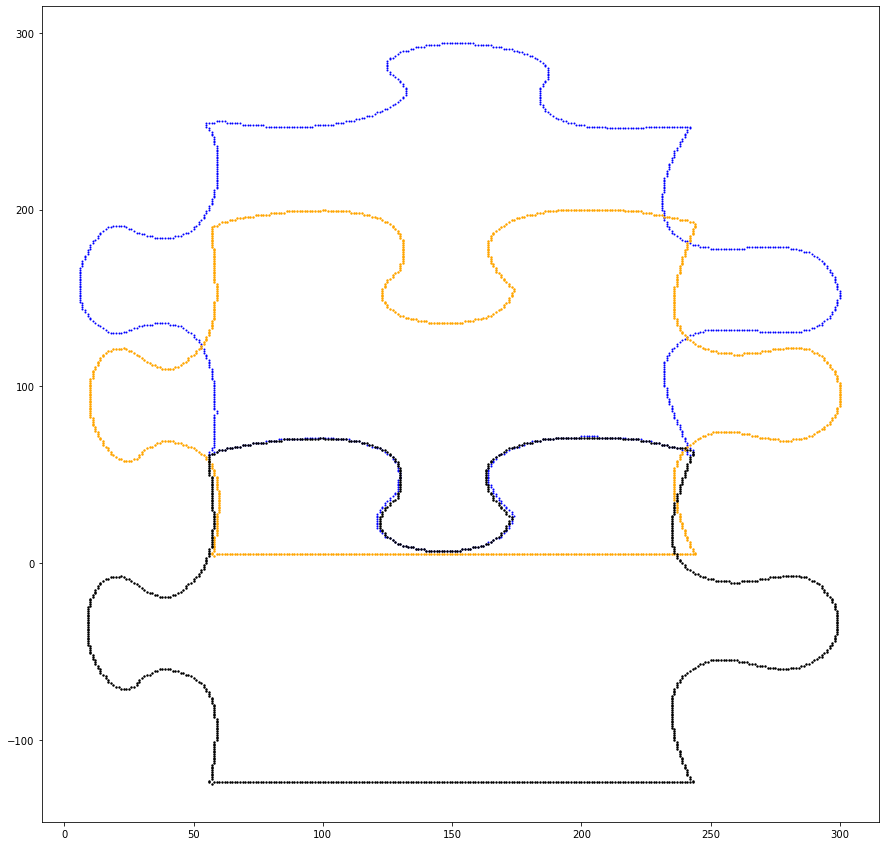

In [53]:
# combine the pieces into one piece

# compute fine alignment over the aligned window

Q_window = [query.sampled_pts[p] for p in list(query.sampled_pts.keys())[ max((mx_Q-length),0):(mx_Q)] ]
T_window = [target.sampled_pts[p] for p in list(target.sampled_pts.keys())[::-1][(mx_T-length):(mx_T)] ]

T_xshift = int((sum([p['x'] for p in Q_window]) - sum([p['x'] for p in T_window])) / length)
T_yshift = int((sum([p['y'] for p in Q_window]) - sum([p['y'] for p in T_window])) / length)

# for all original points in target shifted by fine alignment:
    # add to query with OR function for collisions

# piece points currently in dictionary:  { pt#: {'x':x, 'y':y} }
# convert to 2d array indexed by x and y
Q_pt_array = {}
for p in query.pts.items():
    Q_pt_array[p[1]['x']] = {p[1]['y']:1}
    
Q_pt_array = {}
Q_orig_x = []
Q_orig_y = []

min_x = 999999
min_y = 999999
max_x = -999999
max_y = -999999

for p in query.pts.items():
    if p[1]['x'] not in Q_pt_array.keys():
        Q_pt_array[p[1]['x']] = []   
    Q_pt_array[p[1]['x']].append(p[1]['y'])
    Q_orig_x.append(p[1]['x'])
    Q_orig_y.append(p[1]['y'])
    if p[1]['x'] < min_x:
        min_x = p[1]['x']
    if p[1]['x'] > max_x:
        max_x = p[1]['x']
    if p[1]['y'] < min_y:
        min_y = p[1]['y']
    if p[1]['y'] > max_y:
        max_y = p[1]['y']
    
print((min_x, min_y), (max_x, max_y))

T_orig_x = []
T_orig_y = []
T_shifted_x = []
T_shifted_y = []

for p in target.pts.items():
    if p[1]['x'] + T_xshift not in Q_pt_array.keys():
        Q_pt_array[p[1]['x'] + T_xshift] = []   
    Q_pt_array[p[1]['x'] + T_xshift].append(p[1]['y'] + T_yshift)
    T_orig_x.append(p[1]['x'])
    T_orig_y.append(p[1]['y'])
    T_shifted_x.append(p[1]['x'] + T_xshift)
    T_shifted_y.append(p[1]['y'] + T_yshift)
    if p[1]['x'] + T_xshift < min_x:
        min_x = p[1]['x'] + T_xshift
    if p[1]['x'] + T_xshift > max_x:
        max_x = p[1]['x'] + T_xshift
    if p[1]['y'] + T_yshift < min_y:
        min_y = p[1]['y'] + T_yshift
    if p[1]['y'] + T_yshift > max_y:
        max_y = p[1]['y'] + T_yshift
    
plt.figure(figsize = [15,15])
plt.scatter( Q_orig_x, Q_orig_y, c = 'blue', s=1)
plt.scatter( T_orig_x, T_orig_y, c = 'orange', s=2)
plt.scatter( T_shifted_x, T_shifted_y, c = 'black', s=2)

print((min_x, min_y), (max_x, max_y))

(-54, -185) (360, 354)


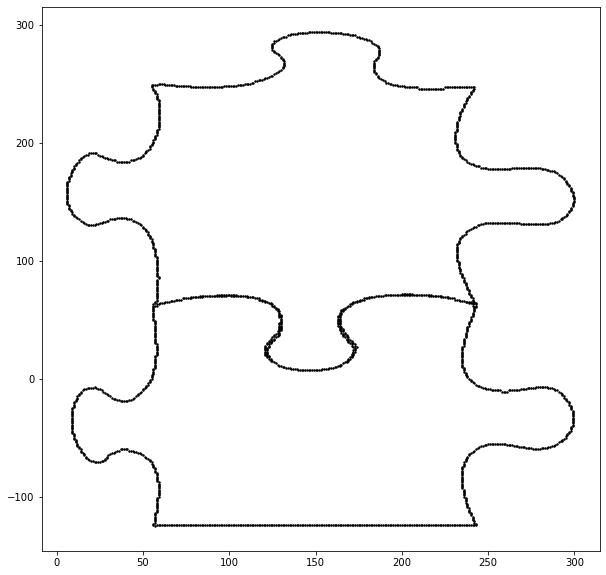

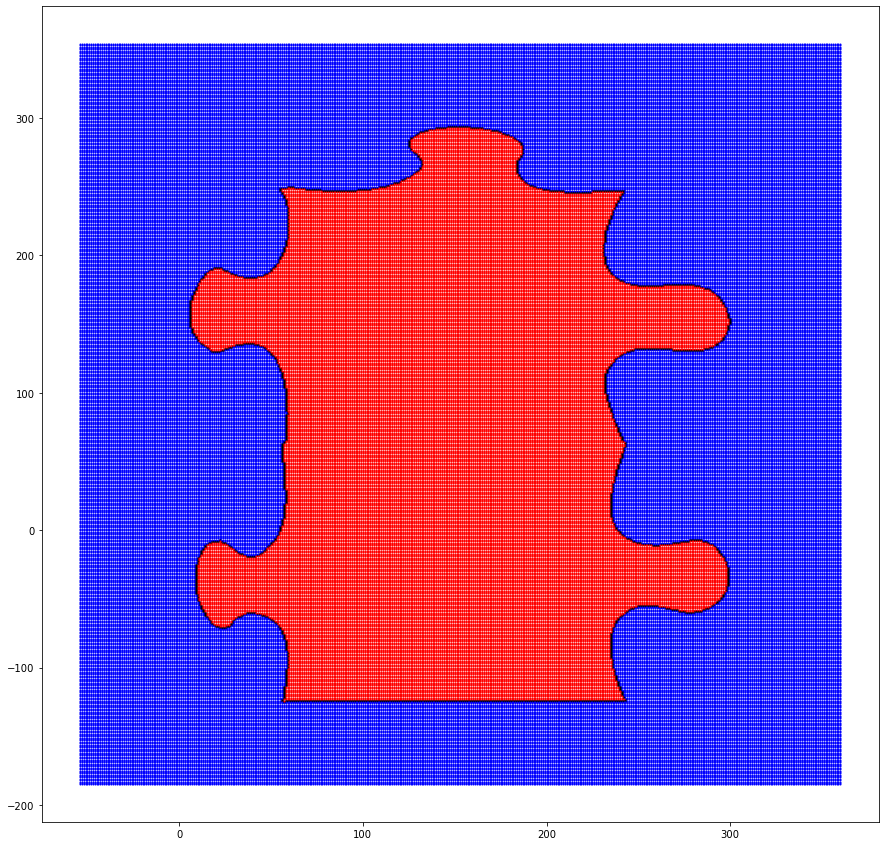

In [65]:
# compute new boundary
# floodfill from exploratory 02 
#convert sparse array to piece_coords complete array
piece_coords = dict()
composite_x = []
composite_y = []

for x in range(min_x-10, max_x+11):
    for y in range(min_y-10, max_y+11):
        if x not in piece_coords:
            piece_coords[x] = dict()

        if y not in piece_coords[x]:
            piece_coords[x][y] = dict()

        v = 1 # default to white point
        if x in Q_pt_array:
            if y in Q_pt_array[x]:
                v = 0 # black point
                composite_x.append(x)
                composite_y.append(y)

        piece_coords[x][y] = {'value': v,
                              'left':None,
                              'right':None,
                              'up':None,
                              'down':None,
                              'visited':False,
                              'outer_border':False}

min_x = min(piece_coords.keys())
max_x = max(piece_coords.keys())
min_y = min(piece_coords[min_x].keys())
max_y = max(piece_coords[min_x].keys())

print((min_x, min_y), (max_x, max_y))

plt.figure(figsize = [10,10])
plt.scatter( composite_x, composite_y, c = 'black', s=2)

# create a place to store (x,y) coordinates
outer_border = list()

# link up the list
for x in range(min_x, max_x+1):
    for y in range(min_y, max_y+1):
        if x > min_x:
            piece_coords[x][y]['left'] = (x-1, y)
        if x < max_x:
            piece_coords[x][y]['right'] = (x+1, y)
        if y > min_y:
            piece_coords[x][y]['down'] = (x, y-1)
        if y < max_y:
            piece_coords[x][y]['up'] = (x, y+1)
            
# start flooding
curr_x = min_x
curr_y = min_y
stack = list()

while True:
    curr_node = piece_coords[curr_x][curr_y]
    curr_node['visited'] = True
    
    # check for black
    if curr_node['value'] == 0:
        curr_node['outer_border'] = True
        (curr_x, curr_y) = stack.pop()
        continue
        
    # try to exapnd right
    if curr_node['right'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['right']
        curr_node['right'] = None
        continue
    if curr_node['down'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['down']
        curr_node['down'] = None
        continue
    if curr_node['left'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['left']
        curr_node['left'] = None
        continue
    if curr_node['up'] is not None:
        stack.append( (curr_x, curr_y) )
        (curr_x, curr_y) = curr_node['up']
        curr_node['up'] = None
        continue
    
    # if all directions fail, back up one if possible
    if len(stack) == 0:
        break
    else:
        (curr_x, curr_y) = stack.pop()

# inside, outside, and border
inside_x = []
inside_y = []
outside_x = []
outside_y = []
border_x = []
border_y = []

for x in piece_coords.keys():
    for y in piece_coords[x].keys():
        if piece_coords[x][y]['outer_border']:
            border_x.append(x)
            border_y.append(y)
        else:
            if piece_coords[x][y]['visited']:
                outside_x.append(x)
                outside_y.append(y)
            else:
                inside_x.append(x)
                inside_y.append(y)

plt.figure(figsize = [15,15])
plt.scatter( border_x, border_y, c = 'black', s=4)
plt.scatter( outside_x, outside_y, c = 'blue', s=1)
plt.scatter( inside_x, inside_y, c = 'red', s=1)

In [69]:
# resample boundary
print(len(piece_coords)*len(piece_coords[0]))
print(piece_coords.keys())

224100
dict_keys([-54, -53, -52, -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39, -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 1

In [ ]:
# put boundary points in order

In [ ]:
# set new combined piece to query and do next alignment